# Monte Carlo Simulation
Monte Carlo Simulation is a type of computational algorithm that uses repeated random sampling to obtain the likelihood of a range of results of occurring.

Also known as the Monte Carlo Method or a multiple probability simulation, Monte Carlo Simulation is a mathematical technique that is used to estimate the possible outcomes of an uncertain event. The Monte Carlo Method was invented by John von Neumann and Stanislaw Ulam during World War II to improve decision making under uncertain conditions. It was named after a well-known casino town, called Monaco, since the element of chance is core to the modeling approach, similar to a game of roulette.

Since its introduction, Monte Carlo Simulations have assessed the impact of risk in many real-life scenarios, such as in artificial intelligence, stock prices, sales forecasting, project management, and pricing. They also provide a number of advantages over predictive models with fixed inputs, such as the ability to conduct sensitivity analysis or calculate the correlation of inputs. Sensitivity analysis allows decision-makers to see the impact of individual inputs on a given outcome and correlation allows them to understand relationships between any input variables.

## How does Monte Carlo simulation work?
Unlike a normal forecasting model, Monte Carlo Simulation predicts a set of outcomes based on an estimated range of values versus a set of fixed input values. In other words, a Monte Carlo Simulation builds a model of possible results by leveraging a probability distribution, such as a uniform or normal distribution, for any variable that has inherent uncertainty. It, then, recalculates the results over and over, each time using a different set of random numbers between the minimum and maximum values. In a typical Monte Carlo experiment, this exercise can be repeated thousands of times to produce a large number of likely outcomes.

Monte Carlo Simulations are also utilized for long-term predictions due to their accuracy. As the number of inputs increase, the number of forecasts also grows, allowing you to project outcomes farther out in time with more accuracy. When a Monte Carlo Simulation is complete, it yields a range of possible outcomes with the probability of each result occurring.

One simple example of a Monte Carlo Simulation is to consider calculating the probability of rolling two standard dice. There are 36 combinations of dice rolls. Based on this, you can manually compute the probability of a particular outcome. Using a Monte Carlo Simulation, you can simulate rolling the dice 10,000 times (or more) to achieve more accurate predictions.

In [1]:
# import routines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

Our environment will be the dataset. It contains 10 ads position per row having values either 1, when the ad is clicked, or 0 when it is not. Every row can be considered as a state in the space, considering it kind of a navigation across multiple pages (on website, for instance) Lets load the dataset and visualize the first few rows

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
env = pd.read_csv('Ads_CTR_Optimisation.csv')
env.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


## Random policy

If we were to not have Q-Learning, we would place the ads randomly at given positions. We will now simulate the same.  

In [4]:
# total rewards earned
reward = 0
# random policy: for every state, choose a random
# position for displaying the ad
for x in range(len(env)):
    action = np.random.randint(0, 10)
    # if the guess was correct, increase the reward
    if env.values[x][action] == 1:
        reward += 1
print("Reward collected: {}".format(reward))

Reward collected: 1317


## Using Max Policy
Another question we might ask, is to display the ad where it is clicked the most number of times. For instance, there might be a certain position where the ad clicked with a higher probability. Since the values of the rows is either 1 or 0, we can sum across the columns and count the number of times ad in the position was clicked. 

In [5]:
clicked_counts = env.values.sum(axis=0)
counts = pd.DataFrame({"ad": np.arange(1, 11), "counts": clicked_counts})
counts.set_index("ad")

,counts
ad,
1,1703
2,1295
3,728
4,1196
5,2695
6,126
7,1112
8,2091
9,952


## Monte Carlo


In [6]:
def random_policy(state):
    """Returns a random available choice"""
    return np.random.randint(0, 10)

def simulate(policy):
    # store the reward-state-action triple
    rsa = []
    for s in range(env.shape[0]):
        # 10% probability that the agent will
        # act randomly
        if np.random.uniform() < 0.1:
            action = np.random.randint(0, 10)
        else:
            action = policy[s]
        reward = env.values[s][action]
        rsa.append((reward, s, action))
        
    # go reverse and distribute rewards
    G = 0
    gamma = 0.3
    first = True
    state_returns = []
    for reward, s , a in reversed(rsa):
        G = G + gamma * reward
        if first:
            first = False
            continue
        else:
            state_returns.append((s, a, G))
    # we want the rewards to be the way
    # they were distributed
    state_returns.reverse()
    return state_returns

In [8]:
from collections import defaultdict

# creates a random policy for every timestep
policy = {s: np.random.randint(0, 10) for s in range(10000)}
Q = np.zeros(env.values.shape)
returns = defaultdict(list)
deltas = []
max_iterations = 1300
for x in range(max_iterations):
    if x % 100 == 0:
        print(x)
    # simulate an episode, and get the
    # reward-state-action triple
    state_returns = simulate(policy)
    change = 0.0
    for state, action, G in state_returns:
        old_q = Q[state][action]
        returns[(state, action)].append(G)
        # calculates the average returns of being in this
        # state
        Q[state][action] = np.mean(returns[(state, action)])
        # save the change so we can later on visualize the rate
        # of convergence
        change = np.maximum(change, np.abs(Q[state][action] - old_q).astype(int))
    deltas.append(change)
    for s in range(10000):
        policy[s] = np.argmax(Q[s, :])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


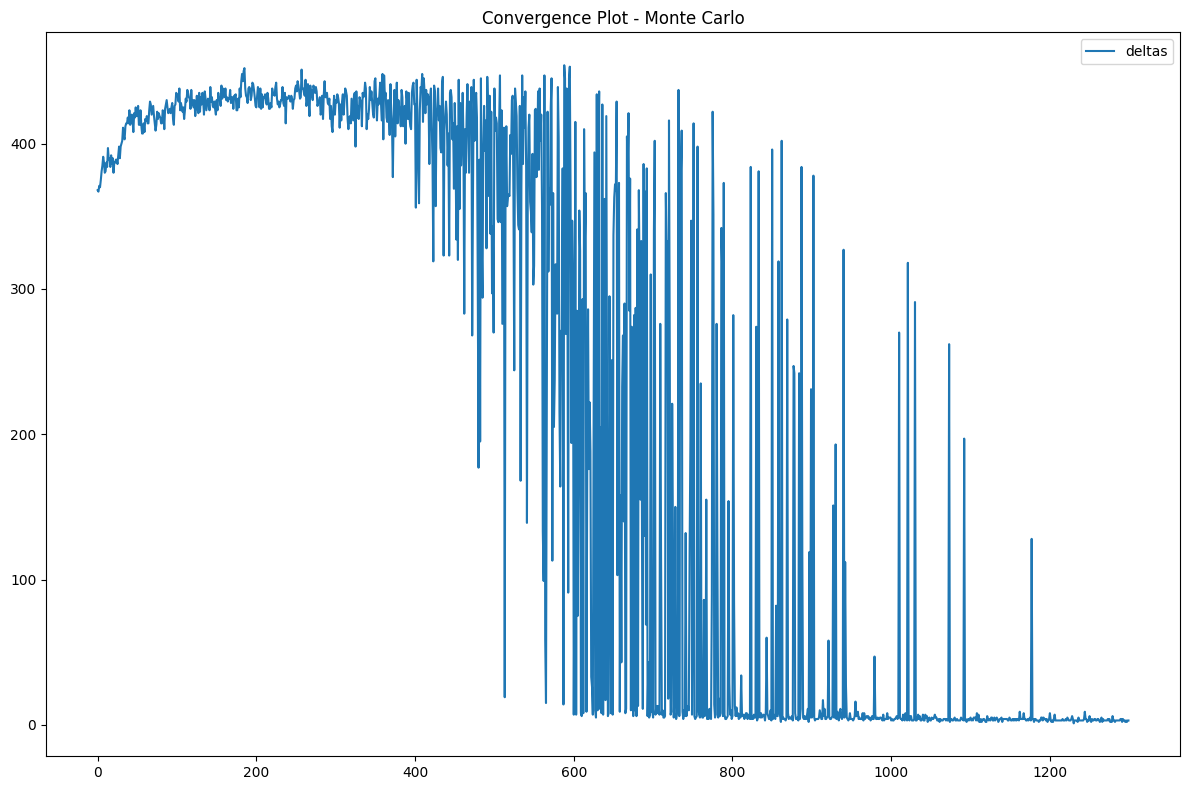

In [9]:
plt.plot(deltas, label="deltas")
plt.legend()
plt.title("Convergence Plot - Monte Carlo")
plt.tight_layout()

In [11]:
# once the policy is learnt, we will test it on the 
# actual environment
reward = 0
for s in range(10000 - 1):
    a = np.argmax(Q[s, :])
    reward += env.values[s][a]
print("reward:", reward)

reward: 1523
